In [1]:
# !pip install python-gdcm

!pip install timm
# !pip install wandb --upgrade
# !pip install madgrad
# !pip install git+https://github.com/lessw2020/Ranger21.git

In [2]:
# note
# review StraifiedGroupKFold

# Library

In [3]:
import sys

sys.path.insert(0, '../input/augmixz')

import numpy as np
import pandas as pd
from glob import glob
import random
from numba import jit
from collections import defaultdict, Counter
from kaggle_secrets import UserSecretsClient
import os
import warnings
from datetime import datetime, timedelta
import time
import gc
from tqdm.notebook import tqdm

# import pydicom
# from pydicom.pixel_data_handlers.util import apply_voi_lut

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.cuda.amp import GradScaler, autocast

# from madgrad import MADGRAD

# from ranger21 import Ranger21

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.bbox_utils import convert_bbox_to_albumentations, convert_bbox_from_albumentations
from augmix import augment_and_mix

import ast
import cv2
import torchvision
import torchvision.transforms as T
import timm
# from timm.data.auto_augment import rand_augment_transform, augment_and_mix_transform
from timm.models.efficientnet import *

import wandb
from torchmetrics import AveragePrecision, Accuracy, AUROC, ConfusionMatrix

import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns

# from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import GroupKFold
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import average_precision_score

from fastprogress.fastprogress import master_bar, progress_bar
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 25)
# %load_ext line_profiler

In [4]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

# Configuration

In [5]:
config = {
    'batch_size': 8,
    'seed': 42,
    'num_classes': 4,
    'fold': 5,
    'image_size': 640,
    'num_workers': 4,
    'box_format': 'pascal'
}

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
# sys.path.insert(0, '../input/sam-optimizer')
# sys.path.insert(0, '../input/autoaugment')


# from sam import SAM
# from autoaugment import ImageNetPolicy


# Seed

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(config['seed'])

# Path

In [8]:
# SAMP_SUB = '/content/data/sample_submission.csv'
TRAIN_IMAGE_LEVEL = '../input/siim-covid19-detection/train_image_level.csv'
TRAIN_STUDY_LEVEL = '../input/siim-covid19-detection/train_study_level.csv'
# TRAIN_PATH = '../input/siim-covid19-detection/train'
# TEST_PATH = '../input/siim-covid19-detection/test'


TRAIN_JPG = '../input/siim-covid19-train/siim-covid19-train/train'
TEST_JPG = '../input/siim-covid19-train/siim-covid19-train/test'
META = '../input/siim-covid19-train/siim-covid19-train/meta.csv'

TDF_PATH = '../input/siim-train-df/train_df.csv'
# TRAIN_DFV2 = '/content/data/train_df_v2.csv'
DUPLICATES = '../input/siim-train-df/duplicates.csv'

# Setup DataFrame

In [9]:
duplicates_df = pd.read_csv(DUPLICATES, header=None)
duplicates_images = []
for idx, row in duplicates_df.iloc[:, 1:].iterrows():
    duplicates_images.append(row.dropna().tolist())
duplicates_images = pd.Series(list(zip(*duplicates_images))[0]).apply(lambda row: row[:-6])

In [10]:
train_df = pd.read_csv(TDF_PATH)
study_lvl = pd.read_csv(TRAIN_STUDY_LEVEL)
image_lvl = pd.read_csv(TRAIN_IMAGE_LEVEL)
meta = pd.read_csv(META)

train_df['integer_label'] = np.argmax(train_df.iloc[:,4:8].values, axis=1)
train_df['ImageInstanceUID'] = train_df['id'].str.split('_').apply(lambda row: row[0])

train_jpg = pd.DataFrame(glob(f'{TRAIN_JPG}/*'), columns=['train_jpg'])
train_jpg['file_name'] = train_jpg.iloc[:,0].str.extract(f'{TRAIN_JPG}/(.*).jpg')

train_df = train_df.merge(train_jpg, left_on='ImageInstanceUID', right_on='file_name')

meta_train = meta[meta['split'] == 'train'].rename(columns={'dim0':'width', 'dim1':'height'}).drop('split', axis=1)
meta_test = meta[meta['split'] == 'test'].rename(columns={'dim0':'width', 'dim1':'height'}).drop('split', axis=1)

train_df = train_df.merge(meta_train, left_on='ImageInstanceUID', right_on='image_id')

box_format = config['box_format']
bboxes_list = []
for bbox, width, height in zip(train_df['boxes'], train_df['width'], train_df['height']):
    temp = []
    for i in range(8):
        try:
            box = ast.literal_eval(bbox)[i]

            x_min = box['x']
            y_min = box['y']
            x_width = box['width']
            y_height = box['height'] 
            box_coco = [x_min, y_min, x_width, y_height]

            album_format = convert_bbox_to_albumentations(box_coco, 'coco', width, height)

            if box_format == 'pascal':
                # x_min = box['x'] * height_ratio
                # y_min = box['y'] * width_ratio
                # x_max = (box['x'] + box['width']) * height_ratio
                # y_max = (box['y'] + box['height']) * width_ratio
                pascal_format = convert_bbox_from_albumentations(album_format, 'pascal_voc', width, height)

                x_min = pascal_format[0]
                y_min = pascal_format[1]
                x_max = pascal_format[2]
                y_max = pascal_format[3]

                box_pascal = [x_min, y_min, x_max, y_max]
                temp.append(box_pascal)
                
            if box_format == 'coco':
                # x_min = box['x'] * height_ratio
                # y_min = box['y'] * width_ratio
                # x_width = box['width'] * height_ratio
                # y_height = box['height'] * width_ratio
                coco_format = convert_bbox_from_albumentations(album_format, 'coco', width, height)
                x_min = coco_format[0]
                y_min = coco_format[1]
                x_width = coco_format[2]
                y_height = coco_format[3]

                box_coco = [x_min, y_min, x_width, y_height]
                temp.append(box_coco)
            
            # [class x_center y_center width height] format
            # range of format is 0~1 optimized for yolov5
            if box_format == 'yolo':

                # x_min = box['x'] * height_ratio
                # y_min = box['y'] * width_ratio
                # x_max = (box['x'] + box['width']) * height_ratio
                # y_max = (box['y'] + box['height']) * width_ratio
                
                # #n normalize bbox with 512
                # x_center = ((x_min + x_max)/2) / config['image_size']
                # y_center = ((y_min + y_max)/2) / config['image_size']
                # b_width = (x_max - x_min) / config['image_size']
                # b_height = (y_max - y_min) / config['image_size']

                yolo_format = convert_bbox_from_albumentations(album_format, 'yolo', width, height)

                x_center = yolo_format[0]
                y_center = yolo_format[1]
                b_width = yolo_format[2]
                b_height = yolo_format[3]

                box_yolo = [x_center, y_center, b_width, b_height]
                temp.append(box_yolo)
            
        except IndexError:
            pass
        except ValueError:
            temp.append(np.nan)
    if box_format != 'yolo':
        if np.isnan(temp).all():
            temp = [[0.0, 0.0, 1.0, 1.0]]

    bboxes_list.append(temp)

bboxes_df = pd.DataFrame(bboxes_list, columns=[f'box_{i}' for i in range(8)])
train_df = pd.concat([train_df, bboxes_df], axis=1)

# drop weird data 
# not negative and no bbox

not_zeros_df = train_df[train_df['integer_label'] != 0]
drop_row = not_zeros_df[not_zeros_df['boxes'].isnull()].index.values
train_df = train_df.drop(drop_row)

train_df = train_df[~train_df['ImageInstanceUID'].isin(duplicates_images)].reset_index(drop=True)

train_df

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,OpacityCount,Opacity,Path,Sex_F,...,file_name,image_id,width,height,box_0,box_1,box_2,box_3,box_4,box_5,box_6,box_7
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,2,1,../input/siim-covid19-detection/train/5776db0c...,0,...,000a312787f2,000a312787f2,3488,4256,"[789.28836, 582.43035, 1815.94498, 2499.73327]","[2245.91208, 591.20528, 3340.5737, 2352.75472]",None,None,None,None,None,None
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,0,0,../input/siim-covid19-detection/train/ff0879eb...,0,...,000c3a3f293f,000c3a3f293f,2320,2832,"[0.0, 0.0, 1.0, 1.0]",None,None,None,None,None,None,None
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,2,1,../input/siim-covid19-detection/train/9d514ce4...,1,...,0012ff7358bc,0012ff7358bc,2544,3056,"[677.42216, 197.97662, 1545.21983, 1197.75876]","[1792.69064, 402.5525, 2409.71798, 1606.910499...",None,None,None,None,None,None
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,1,1,../input/siim-covid19-detection/train/28dddc85...,1,...,001398f4ff4f,001398f4ff4f,3520,4280,"[2729.0, 2181.33331, 3677.00012, 2785.33331]",None,None,None,None,None,None,None
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,2,1,../input/siim-covid19-detection/train/dfd9fdd8...,0,...,001bd15d1891,001bd15d1891,2800,3408,"[623.23328, 1050.0, 1337.23328, 2156.0]","[2578.56661, 998.66667, 3241.23328, 2118.66667]",None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5989,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06,1,0,0,0,0,0,../input/siim-covid19-detection/train/7e6c6846...,1,...,ffcc6edd9445,ffcc6edd9445,4240,3480,"[0.0, 0.0, 1.0, 1.0]",None,None,None,None,None,None,None
5990,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e,1,0,0,0,0,0,../input/siim-covid19-detection/train/8332bdad...,1,...,ffd91a2c4ca0,ffd91a2c4ca0,2800,3408,"[0.0, 0.0, 1.0, 1.0]",None,None,None,None,None,None,None
5991,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814,0,1,0,0,3,1,../input/siim-covid19-detection/train/7eed9af0...,0,...,ffd9b6cf2961,ffd9b6cf2961,2388,3050,"[2197.38566, 841.07361, 2513.80265, 1292.71119]","[2375.87717, 1830.89015, 2643.6144700000004, 2...","[707.25199, 722.07926, 1099.3924299999999, 157...",None,None,None,None,None
5992,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d,0,1,0,0,2,1,../input/siim-covid19-detection/train/a0cb0b96...,0,...,ffdc682f7680,ffdc682f7680,3488,4256,"[2729.2708299999995, 332.26044, 4225.52099, 29...","[1005.8125, 1584.67711, 1668.0416300000002, 23...",None,None,None,None,None,None


In [11]:
# train_df.to_csv('train_dfv4.csv', index=False)

# Split

In [12]:
def stratified_group_k_fold(X, y, groups, k, seed=config['seed']):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

def get_distribution(y_vals):
        y_distr = Counter(y_vals)
        y_vals_sum = sum(y_distr.values())
        return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [13]:
folds_df = train_df.copy()

train_x = folds_df.index.values
train_y = folds_df.integer_label.values
groups = folds_df.image_id


for fold, (train_idx, valid_idx) in enumerate(stratified_group_k_fold(train_x, train_y, groups, k=5)):
    folds_df.loc[folds_df.iloc[valid_idx].index, 'fold'] = fold

folds_df['fold'] = folds_df['fold'].astype(np.int)
folds_df.groupby(['fold', folds_df.integer_label]).size()

fold  integer_label
0     0                344
      1                569
      2                209
      3                 78
1     0                344
      1                569
      2                209
      3                 78
2     0                344
      1                569
      2                208
      3                 78
3     0                344
      1                568
      2                208
      3                 77
4     0                344
      1                568
      2                208
      3                 78
dtype: int64

# Dataset

In [14]:
class CustomDataset(Dataset):
    def __init__(self, df, transforms=None):
        super().__init__()
        self.df = df.reset_index().rename(columns={'index': 'real_image_idx'})
        self.real_image_idx = self.df['real_image_idx']
        # self.image_path = df['Path'].tolist() # dicom
        self.image_path = df['train_jpg'].tolist()
        self.image_ids = df['image_id']
        self.transforms = transforms

    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_ids = self.df.iloc[idx]['image_id']
        # call get images private method
        image = torch.tensor(self._get_images(idx), dtype=torch.float32)
#         image = torch.tensor(self._normalize(image), dtype=torch.float32)
        # capture all targets into dict
        target = {}
        target['labels'] = torch.tensor(self.df[
            ['Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']
        ].iloc[idx].values, dtype=torch.int64)
        target['image_idx'] = torch.tensor([self.real_image_idx.tolist()[idx]])

                
        if self.transforms:
            image = image.numpy()
            transforms_dict = {
                'image': image,
                'class_labels': target['labels']
            }
            
            transformed = self.transforms(**transforms_dict)
            # replace with transformed image and labels
            image = torch.tensor(transformed['image'], dtype=torch.float32)
            target['labels'] = torch.tensor(transformed['class_labels'], dtype=torch.int64)
            
        return image, target, image_ids
    
    
    def _get_images(self, idx):
        image = cv2.imread(self.image_path[idx], 0)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
#         image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        return image

    def _normalize(self, image):
        max_image = image.max()
        min_image = image.min()
        norm_image = (image - min_image) / (max_image - min_image)
        return norm_image

# Albumentations

In [15]:
class RandomAugMix(A.ImageOnlyTransform):
    """
    https://github.com/hh-xiaohu/Image-augementation-pytorch
    """
    def __init__(self, severity=5, width=4, depth=-1, alpha=1., always_apply=False, p=0.5):
        super(RandomAugMix, self).__init__(always_apply, p)
        self.severity = severity
        self.width = width
        self.depth = depth
        self.alpha = alpha

    def apply(self, image, **params):
        image = augment_and_mix(
            image,
            self.severity,
            self.width,
            self.depth,
            self.alpha
        )
        return image
    
    def get_transform_init_args_names(self):
        return ('severity', 'width', 'depth', 'alpha')

def get_train_transforms():
    return A.Compose([
#         A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.5),
#         A.RandomBrightness(p=0.5),
#         A.Rotate(limit=15, p=0.5),
#         A.Blur(p=0.5),
#         A.RandomResizedCrop(p=0.5, height=config['image_size'], width=config['image_size']),
#         A.Cutout(num_holes=10, max_h_size=16, max_w_size=16, p=0.5),
        A.Resize(config['image_size'], config['image_size']),
#         RandomAugMix(p=0.5),
        ToTensorV2()
    ])


def get_valid_transforms():
    return A.Compose([
        A.Resize(config['image_size'], config['image_size']),
        ToTensorV2()
    ])

# Load dataset helper

In [16]:
def get_train_dataset(fold):
    return CustomDataset(df=folds_df[folds_df['fold'] != fold],
                         transforms=get_train_transforms())

def get_valid_dataset(fold):
    return CustomDataset(df=folds_df[folds_df['fold'] == fold],
                         transforms=get_valid_transforms())

def collate_fn(batch):
    return tuple(zip(*batch))

def get_train_loader(dataset, batch_size):
    return DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=config['num_workers'],
                      pin_memory=True, sampler=RandomSampler(dataset), collate_fn=collate_fn)

def get_valid_loader(dataset, batch_size):
    return DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=config['num_workers'],
                      pin_memory=True, sampler=SequentialSampler(dataset), collate_fn=collate_fn)

In [17]:
train_dataset = get_train_dataset(0)
# valid_dataset = get_valid_dataset(0)

# Draw a sample image from dataset

(tensor([[[ 99.9797,  98.0859, 100.0742,  ..., 165.0742, 163.2266, 168.5898],
         [ 92.0164,  90.0078,  97.7148,  ..., 159.0625, 165.4453, 167.2234],
         [ 97.0367,  97.2203,  96.4375,  ..., 165.7578, 160.3148, 168.4133],
         ...,
         [  1.6477,  18.5969,  55.7305,  ..., 204.0000, 209.3320, 200.3375],
         [  1.0781,  70.0234, 109.0000,  ..., 197.5000, 204.7961, 193.4641],
         [ 53.0453,  81.0578,  87.1055,  ..., 202.0117, 199.7555, 197.2930]]]), {'labels': tensor([1, 0, 0, 0]), 'image_idx': tensor([1])}, '000c3a3f293f')
image_max:  255.0  image_min:  0.0
image_shape:  (640, 640)
image_id 000c3a3f293f


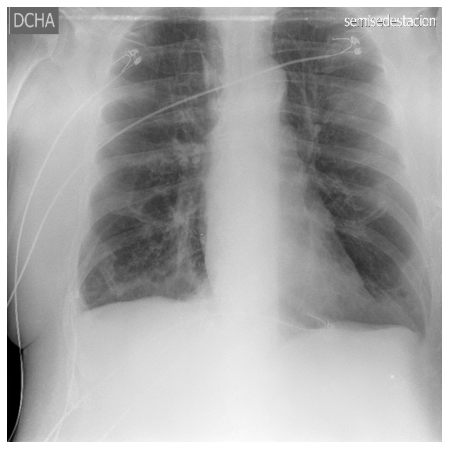

In [18]:
def draw_sample_dataset(dataset, num):
    image, target, image_id = dataset[num]
    print(dataset[num])
    image = image[0].numpy()
#     image = image[:, :, 0]
    print('image_max: ', image.max(), ' image_min: ', image.min())
    print('image_shape: ', image.shape)
    print('image_id', image_id)
        
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.set_axis_off()
    ax.imshow(image, cmap='gray')
    plt.show()


draw_sample_dataset(train_dataset, 0)

# Sample DataLoader

# Model

In [19]:
class Effnet(nn.Module):
    def __init__(self, model_name, num_classes=config['num_classes'], pretrained=True):
        super().__init__()
        eff = model_name(pretrained=True, drop_rate=0.3, drop_path_rate=0.2, in_chans=1)
        self.b0 = nn.Sequential(
            eff.conv_stem,
            eff.bn1,
            eff.act1,
        )
        
        self.b1 = eff.blocks[0]
        self.b2 = eff.blocks[1]
        self.b3 = eff.blocks[2]
        self.b4 = eff.blocks[3]
        self.b5 = eff.blocks[4]
        self.b6 = eff.blocks[5]
        self.b7 = eff.blocks[6]
        self.b8 = nn.Sequential(
            eff.conv_head,
            eff.bn2,
            eff.act2,
        )
        self.logit = nn.Linear(2560, num_classes)
#         self.logit = nn.Sequential(
#             nn.Linear(2560, 1280),
#             nn.SiLU(inplace=True),
#             nn.Dropout()
#         )
        
        self.mask = nn.Sequential(
            nn.Conv2d(224, 128
                      , kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 1, kernel_size=1, padding=0),
        )
    
#         self.aux_head = nn.Sequential(
#             nn.Conv2d(224, 1344, kernel_size=(1, 1), stride=(1, 1), bias=False), # effnetb7_ns
#             nn.BatchNorm2d(1344, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
#             nn.SiLU(inplace=True),
#         )
#         self.aux_logit = nn.Linear(1344, num_classes)

    def forward(self, x):
        batch_size = len(x)
        
        x = self.b0(x)
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.b5(x)
        #------------
#         aux = self.aux_head(x)
#         aux = F.adaptive_avg_pool2d(aux, 1).reshape(batch_size, -1)
#         aux = self.aux_logit(aux)
        aux = self.mask(x)
        #-------------
        x = self.b6(x)
        x = self.b7(x)
        x = self.b8(x)
        x = F.adaptive_avg_pool2d(x,1).reshape(batch_size,-1)
        #x = F.dropout(x, 0.5, training=self.training)
        logit = self.logit(x)
        return logit, aux

In [20]:
class Metrics:
    def __init__(self):
        self._reset()
        
    def _reset(self):
        self.step = 0
        self.batch_sum = 0
        
        self.accuracy_top1_sum = 0
        self.accuracy_top2_sum = 0
        self.proba_list = []
        self.truth_list = []
        self.auroc_sum = 0
        
        self.top_1 = 0
        self.top_2 = 0
        self.mAP = 0
        self.AUROC = 0
        self.ConMat = 0
        
        self.acc_top1 = Accuracy(top_k=1).to(device)
        self.acc_top2 = Accuracy(top_k=2).to(device)
        self.AP = AveragePrecision(num_classes=config['num_classes']).to(device)
        self.auroc = AUROC(num_classes=config['num_classes']).to(device)
        self.conmat = ConfusionMatrix(num_classes=config['num_classes']).to(device) 
        
    def update(self, y_true_nd, y_true_1d, y_pred_nd, y_pred_1d, batch_num):
        self.step += 1
        self.batch_num = batch_num
        self.batch_sum += batch_num
        
        self.accuracy_top1_sum += self.acc_top1(y_pred_nd, y_true_1d).item()
        self.top_1 = self.accuracy_top1_sum / self.step
        
        self.accuracy_top2_sum += self.acc_top2(y_pred_nd, y_true_1d).item()
        self.top_2 = self.accuracy_top2_sum / self.step
  
        self.proba_list.append(y_pred_nd)
        self.truth_list.append(y_true_1d)
        
    def calculate(self):
        self.proba = torch.cat(self.proba_list)
        self.truth = torch.cat(self.truth_list)
        self.mAP = torch.stack(self.AP(self.proba, self.truth)).mean().item()
        self.AUROC = self.auroc(self.proba, self.truth).item()
        self.ConMat = self.conmat(self.proba, self.truth)
        
    def show_confmat(self):
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        x_axis_labels = ['0 negative', '1 typical', '2 indeterminate', '3 atypical']
        y_axis_labels = ['0 negative', '1 typical', '2 indeterminate', '3 atypical']
        ax = sns.heatmap(self.ConMat, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
        ax.set(title="Heatmap",
              xlabel="Prediction",
              ylabel="Truth",
              )
        plt.xticks(rotation=45)
#         sns.set(font_scale=1.3)
        plt.show()

In [21]:
def get_tta(number, image):
    image = image.permute(1, 2, 0).float().cpu().numpy()
    if number == 0:
        # HFLIP
        augmented = cv2.flip(image, 1)
    elif number == 1:
        # scale up to 1.33
        augmented = cv2.resize(image, (int(config['image_size'] * 1.33), int(config['image_size'] * 1.33)))
    elif number == 2:
        # rotate 90 clockwise
        augmented = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        
    return torch.unsqueeze(torch.as_tensor(augmented), dim=0).to(device)

def prediction_tta(net, images):
    net.eval().to(device)
    result_list = []
    
    for image in images:
        batch_result_list = []
        
        for i in range(3):
            augmented_image = get_tta(i, image)
            
            with torch.no_grad():
                outputs, aux_out = net(torch.unsqueeze(augmented_image, dim=0))    
            prob = F.softmax(outputs)
            batch_result_list.append(prob)
            
        with torch.no_grad():
            orig_outputs, aux_oputs = net(torch.unsqueeze(image, dim=0))
            orig_prob = F.softmax(orig_outputs)
        batch_result_list.append(orig_prob)
        
        result_list.append(torch.stack(batch_result_list).mean(dim=0)[0])
    
    return torch.stack(result_list)

In [22]:
def get_cv(model, valid_loader, fold, apply_tta):
    criterion = nn.CrossEntropyLoss()
    metrics = Metrics()
    model.eval().to(device)
    
    for images, targets, image_ids in progress_bar(valid_loader):
        images = torch.stack(images).float().to(device)
        batch_size = images.shape[0]
        labels = torch.stack([target['labels'] for target in targets])
        
        with torch.no_grad():
            if apply_tta:
                prob = prediction_tta(model, images)
            else:
                outputs, aux_outputs = model(images)
                loss = criterion(outputs, torch.max(labels, axis=1)[1])
                prob = F.softmax(outputs)
        
        true_labels_1d = torch.max(labels, 1)[1]
        pred_labels_1d = torch.max(prob, 1)[1]
        
        metrics.update(
            y_true_nd = labels.detach(),
            y_true_1d = true_labels_1d.detach(),
            y_pred_nd = prob.detach(),
            y_pred_1d = pred_labels_1d.detach(),
            batch_num = batch_size
        )
    metrics.calculate()
    metrics.show_confmat()
    print(f'Fold {fold}\nloss: {loss.item()}\nmAP: {metrics.mAP}\nAUROC: {metrics.AUROC}\nTop1: {metrics.top_1}\nTop2: {metrics.top_2}\n')
    return [fold, loss.item(), metrics.mAP, metrics.AUROC, metrics.top_1, metrics.top_2]

In [23]:
def get_model(model_name, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    model = Effnet(model_name)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    del checkpoint
    gc.collect()
    return model

In [24]:
def make_cv_df(cv_list, agg_list=[np.mean, np.std], to_csv=False):
    cv_df = pd.DataFrame(cv_list, columns=['Fold', 'Loss', 'mAP', 'AUROC', 'Acc@1', 'Acc@2'])
    cv_df['mAP*2/3'] = cv_df['mAP'].apply(lambda row: row *(2/3))
    cv_df = cv_df[['Fold', 'Loss', 'mAP', 'mAP*2/3', 'AUROC', 'Acc@1', 'Acc@2']]
    cv_agg = cv_df.agg(agg_list).drop('Fold', axis=1).reset_index().rename({'index':'Fold'}, axis=1)
    cv_df = cv_df.append(cv_agg).reset_index(drop=True)
    cv_df.to_csv('cv_df.csv', index=False)
    return cv_df

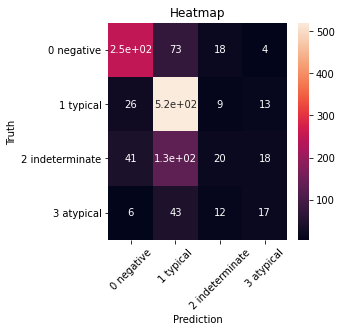

Fold 0
loss: 0.7860516905784607
mAP: 0.5585950016975403
AUROC: 0.8139344453811646
Top1: 0.6725
Top2: 0.8558333333333333



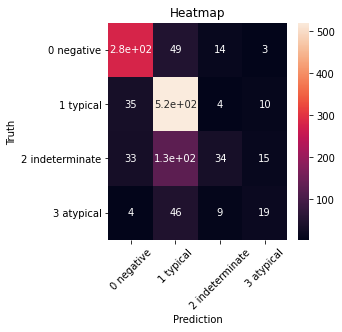

Fold 1
loss: 0.6079323887825012
mAP: 0.6186725497245789
AUROC: 0.8507439494132996
Top1: 0.7091666666666666
Top2: 0.89



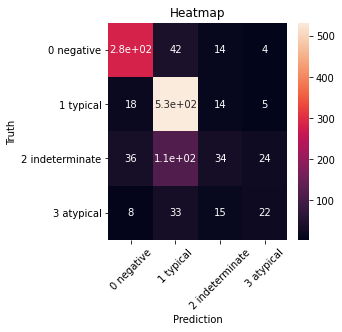

Fold 2
loss: 0.6074427366256714
mAP: 0.6144336462020874
AUROC: 0.856732964515686
Top1: 0.7273809524377187
Top2: 0.8908333333333334



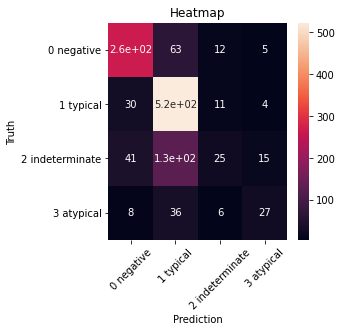

Fold 3
loss: 1.1404675245285034
mAP: 0.5977232456207275
AUROC: 0.8325818777084351
Top1: 0.7001666667064032
Top2: 0.8765000001589457



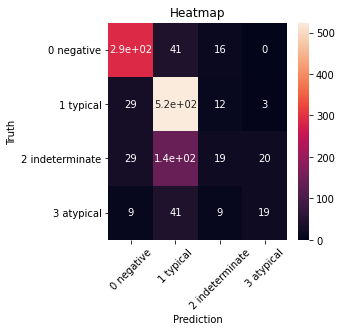

Fold 4
loss: 1.32675302028656
mAP: 0.619381844997406
AUROC: 0.8537904024124146
Top1: 0.7080555556217829
Top2: 0.8813888889551162



In [25]:
model = get_model(tf_efficientnet_b7_ns, checkpoint_path='../input/offlinemodeldependency/effnetb7_ns_masked/effnetb7_ns_masked/best-score.pth')
cv_list = []
for fold in progress_bar(range(config['fold'])):
    config['image_size'] = 640
    valid_dataset = get_valid_dataset(fold)
    valid_loader = get_valid_loader(valid_dataset, config['batch_size'])
    cv = get_cv(model, valid_loader, fold, apply_tta=False)
    cv_list.append(cv)

In [26]:
cv_df = make_cv_df(cv_list, to_csv=True)
cv_df

,Fold,Loss,mAP,mAP*2/3,AUROC,Acc@1,Acc@2
0,0,0.786052,0.558595,0.372397,0.813934,0.672500,0.855833
1,1,0.607932,0.618673,0.412448,0.850744,0.709167,0.890000
2,2,0.607443,0.614434,0.409622,0.856733,0.727381,0.890833
3,3,1.140468,0.597723,0.398482,0.832582,0.700167,0.876500
4,4,1.326753,0.619382,0.412921,0.853790,0.708056,0.881389
5,mean,0.893729,0.601761,0.401174,0.841557,0.703454,0.878911
6,std,0.325432,0.025674,0.017116,0.018083,0.019970,0.014227
